# Analyzing Countries' Relative Event Performance in the WCA

The [Rubik's Cube](https://www.smithsonianmag.com/innovation/brief-history-rubiks-cube-180975911/) is one of the most popular and best-selling toys in the history of the world.  Invented in 1974 by Hungarian architect Erno Rubik, the cube has fascinated minds and captivated enthusiasts for decades.  It didn't take long for a competitive community surrounding the cube to develop, along with an officiating organization, the World Cube Association (WCA).  The first official WCA competition was the World Championship held in 1982 in Budapest, Hungary.  [Minh Thai](https://www.speedsolving.com/wiki/index.php/Minh_Thai) won the competition, with his fastest solve coming in at 22.95 seconds.

Speedcubing has come quite a long way since the original 1982 world championship.  These days, a 22 second solve wouldn't get you past the first round in a local competition, let alone a world championship.  Countless advancements have been made in speedsolving methods, perhaps most notably the development and refinement of the [CFOP or Fridrich Method](https://www.rubiks.com/en-us/blog/how-to-solve-the-rubiks-cube-fridrich-method-cfop-stage-1), which is by far the most widely used 3x3 speedsolving method today.  

Speedcubing has expanded in many other ways as well.  While the original world championship only had the 3x3x3 Rubik's Cube, today the WCA recognizes 17 different events.  Some of them are straightforward variations on the 3x3x3 Rubik's cube, such as the smaller 2x2x2 Rubik's Cube, or some larger cubes (up to 7x7x7).  Some other events that the WCA recognizes include: 
- [3x3x3 One-Handed](https://www.youtube.com/watch?v=LvFtz4QAP5g)
- [3x3x3 Blindfolded](https://www.youtube.com/watch?v=MJew86mY3wY)
- [Pyraminx](https://www.youtube.com/watch?v=buod0m1u-qU)
- [Skewb](https://www.youtube.com/watch?v=p-b2PW9CQho)
- [Square-1](https://www.youtube.com/watch?v=4LSLK_CGIus)

The three of us have been speedcubing for at least 7 years each, and became deeply involved in the speedcubing community for quite some time.  One observation that we made over the years is that certain events seemed to be more popular in certain countries.  The most notable example of this that I can recall was the popularity of Skewb in Poland.  For example, back in 2017, the top 3 skewb average results in the world were all from [Polish cubers](https://www.worldcubeassociation.org/results/rankings/skewb/average?years=until+2017).  It's entirely possible that this is mostly just a coincidence.  But this leads into what we will be investigating in this project.  We wish to test the strength of the connection between the events that a cuber ranks the highest in and competes the most in with their country of residence.  Are there other subtle relationships between certain countries and certain events?  And finally, we will use machine learning to learn a model that will predict the most likely country of residence of a particular cuber based on (A) the events that he/she competes in most frequently, and (B) the events that he/she ranks the highest in.  Hopefully, we will be able to predict their country of residence with a better accuracy than a random guess would yield.  



### Obtaining Data

If you wish to follow along with this tutorial, start by creating a working directory to hold the WCA data and your Jupyter Notebook.

The WCA's data can be downloaded [here](https://www.worldcubeassociation.org/results/misc/export.html).  Click on the link for the TSV zip file, download it, and then extract the files to some folder (not your working directory).  Inside the extracted folder there are numerous files, most of which we won't need.  Move the following files into your working directory:
- WCA_export_Persons
- WCA_export_RanksAverage
- WCA_export_RanksSingle
- WCA_export_Results

At this point you should also create your Jupyter Notebook (in the same directory).

The data that we need to use for this analysis is not all in the same file, so we will need to create a few separate dataframes and then merge and wrangle them a bit to get them in the format that we want.  

### Warming Up

While most people have heard of the Rubik's Cube, most have not attended a WCA competition, and likely do not know how these competitions work.  So before jumping into the heart of our country-based analysis, let's get our hands dirty with some of this data.  This will familiarize the reader with the dataset, and will provide an opportunity to explain some aspects of cubing that are relevant to our analysis.  

To begin, let's load in the RanksAverage and RanksSingle datasets and then wrangle them into a useful form.  

In [161]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

# Note: the low_memory parameter is critical here.  
# Without it, we would have inconsistencies in our datatypes, which would require a bit more wrangling to resolve.
df_average = pd.read_csv("WCA_export_RanksAverage.tsv", sep = '\t', low_memory=False)
df_single = pd.read_csv("WCA_export_RanksSingle.tsv", sep = '\t', low_memory=False)

print("Averages: \n", df_average.head())
print("\nSingles: \n", df_single.head())

Averages: 
      personId eventId  best  worldRank  continentRank  countryRank
0  2018KHAN28     222   105          1              1            1
1  2013EGDA02     222   121          2              1            1
2  2012CALL01     222   123          3              2            2
3  2016LIJI05     222   125          4              1            1
4  2012PATE01     222   127          5              2            1

Singles: 
      personId eventId  best  worldRank  continentRank  countryRank
0  2014CZAP01     222    49          1              1            1
1  2017AGGA01     222    51          2              1            1
2  2014RZEW01     222    52          3              2            2
3  2015ZUBO01     222    52          3              2            2
4  2016JONE04     222    53          5              1            1


Let's pause here to sort through what we're looking at.

How do we interpret one of these rows?  Let's interpret the first row in each table.  
- Averages table: The competitor with the WCA ID 2018KHAN28 ([Zayn Khanani](https://www.worldcubeassociation.org/persons/2018KHAN28)) has a personal best official 2x2x2 average of 1.05 seconds.  This is ranked number 1 in the world (and obviously, number 1 in the continent and country as well).  
- Singles table: The competitor with the WCA ID 2014CZAP01 ([Maciej Czapiewski](https://www.worldcubeassociation.org/persons/2014CZAP01)) has a personal best official 2x2x2 single of 0.49 seconds.  This is ranked number 1 in the world (and obviously, number 1 in the continent and country as well).

A competitor's best single is exactly as you would expect - it is the fastest solve they have even completed in an official competition.  The average is a little more complicated.  For most events, such as 2x2x2 through 5x5x5, competitors complete 5 solves for an average.  The best and worst solves are dropped off, and the mean of the middle 3 is calculated and recorded as their "average of 5."  For some other events however, such as 6x6x6 and 7x7x7, competitors only complete 3 solves, and their average is computed as the mean of those three times.  So since the top of the ranks table has 2x2x2 results, we're looking at the best average of 5 that these competitors has completed in competition.  

The reader may notice that the times are given in centiseconds (e.g., 49 for 0.49 seconds).  We'd like to replace these with their value in seconds, as a float.  We'll also drop a few events that are not recognized anymore, drop continental and country ranks entirely, and then merge these two into a single dataframe.  

In [162]:
df = pd.merge(df_single, df_average, how='right', on=['personId', 'eventId'])

# rename columns to more descriptive names after the merge
df.rename({'best_x': 'best_single', 'worldRank_x': 'worldRank_single', 'continentRank_x': 'continentRank_single', 
           'countryRank_x': 'countryRank_single', 'best_y': 'best_average', 'worldRank_y': 'worldRank_average',
           'continentRank_y': 'continentRank_average', 'countryRank_y': 'countryRank_average'}, axis = 1, inplace = True)

# scale the times to what they actually are (by default, times like 0.49 seconds were recorded as 49)
df['best_single'] = np.float64(df['best_single'] / 100.0)
df['best_average'] = np.float64(df['best_average'] / 100.0)

# drop continental and country ranks since we don't need them for our analysis (we'll just focus on world rankings)
df.drop(['continentRank_single', 'countryRank_single', 'continentRank_average', 'countryRank_average'], axis = 1, inplace=True)

# Magic (eventId magic) and Master Magic (eventId mmagic) are old events that are not recognized anymore, so we drop them.
df.drop(df[df['eventId'] == 'magic'].index, inplace=True)
df.drop(df[df['eventId'] == 'mmagic'].index, inplace=True)

So what analysis could we do with just this information alone?  One thing we could examine is the relationship between cubers' best singles and averages for different events.  Let's start by making a scatterplot (along with a line of best fit) for the top 200 competitors (based on average) for a few different events to see if we notice any disparities.  

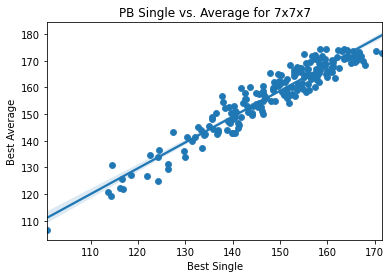

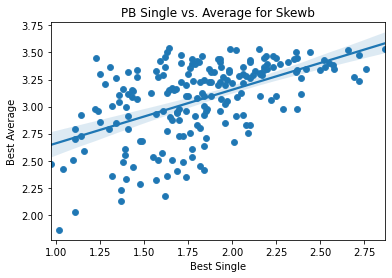

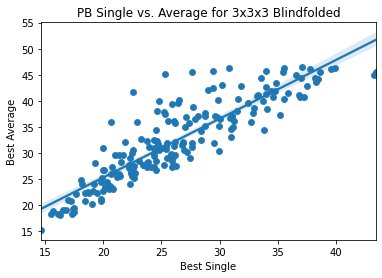

In [163]:
def plot_event(sample_data, event_name):
    # plot their PB single (x-axis) vs. their PB average (y-axis)
    ax = sns.scatterplot(data = sample_data, x = 'best_single', y = 'best_average')

    # plot a line of best fit for the data
    sns.regplot(ax = ax, data = sample_data, x = 'best_single', y = 'best_average')

    ax.set_xlabel('Best Single')
    ax.set_ylabel('Best Average')
    ax.set_title('PB Single vs. Average for ' + event_name);

plot_event(df[df['eventId'] == '777'][0:200], "7x7x7")
plt.figure()
plot_event(df[df['eventId'] == 'skewb'][0:200], "Skewb")
plt.figure()
plot_event(df[df['eventId'] == '333bf'][0:200], "3x3x3 Blindfolded")

The 7x7x7 data certainly looks to fit the line the best, and the other two each have a distinctness to their "shapes".  I think the most interesting aspect of these 3 plots is the upward bulge in the 3x3x3 blindfolded plot.  The 3x3x3 blindfolded event uses a mean of 3 instead of average of 5.  However, this means that none of the solves are dropped, so if any one of your solves is a DNF (did not finish), which happens quite often in blindfolded events due to mistakes in memorization of the cube, your entire average will not count.  Because of this, in competition people will go for the fastest possible single most of the time.  This leads to a lot of DNF averages, but every once in a while a competitor will get a very fast single.  Occasionally, a fast blind solver may decide to play it safe for one round and specifically try to get a complete mean of 3.  I think that this is why we see the data spreading out a bit over the regression line - cubers that are purposefully trying to go slower for a better chance of solving the cube in order to get a mean, after they've already gotten a really good single.  

Hopefully that small introduction to the data was helpful and you are now more familiar with the WCA and Rubik's Cube Competitions.  Now let's shift gears to the main part of our analysis - examining the relationship between countries and events.

In [172]:
# We will begin by whittling down the persons table to just each person's WCA ID and 
# country of residence, and then we will use the WCA ID as the table's index.  First we must
# load in the dataset with pandas. 
df_persons = pd.read_csv("WCA_export_Persons.tsv", sep = '\t', low_memory=False)

# only retain the two columns from the persons table that we need.
df_persons = df_persons[['id','countryId']]

# pivot the original dataframe from long to wide format.  This will put it in a format closer to what we want for our 
# machine learning and analysis later on.  We'll just use their single world ranking for now and ignore their average
# world ranking
full_df = df.pivot(index = 'personId', columns = 'eventId', values = 'worldRank_single')
full_df = pd.merge(full_df, df_persons, how = 'left', left_on = 'personId', right_on = 'id')
full_df.set_index('id', inplace=True)

# convert the values in the table to percentiles (really 1 minus the percentile) instead of raw rankings.  
for event in full_df.columns[:-1]:
    event_max = full_df[event].max()
    full_df[event] = full_df[event] / event_max

# display part of the table
full_df.sample(8, random_state = 7)

,222,333,333bf,333fm,333ft,333oh,444,444bf,555,555bf,666,777,clock,minx,pyram,skewb,sq1,countryId
id,,,,,,,,,,,,,,,,,,
2018BALA25,0.172118,0.124640,NaN,NaN,NaN,0.451401,0.264353,NaN,0.487962,NaN,NaN,NaN,NaN,0.307751,0.208681,NaN,NaN,Romania
2017CADI02,0.175818,0.021964,NaN,NaN,NaN,0.342040,0.016976,NaN,0.051920,NaN,0.289294,NaN,NaN,NaN,NaN,NaN,NaN,Chile
2015MOWE01,0.177996,0.265347,NaN,NaN,NaN,NaN,0.692142,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.445457,0.430252,NaN,USA
2016IVAN02,NaN,0.944905,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ukraine
2016YANG30,0.298283,0.339963,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.608866,0.853886,NaN,USA
2015ZHAN45,0.662984,0.356692,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,China
2016MOSQ02,0.787486,0.520886,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Colombia
2015KSIA01,NaN,0.872343,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Poland
